In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from my_OIB_functions import *
#from datetime import datetime, date, time
import datetime as dt
from pylab import *

from scipy import signal

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option("display.max_rows",30)
pd.set_option("precision",18)
pd.set_option('expand_frame_repr', False)

In [2]:
headers = ('UTCDate','UTCTime','UTCTime','UTCTime','Latitude','Longitude','H-Ell',
           'Pitch','Roll','Heading','NS','PDOP','AccBiasZ')
# dtypes = {'UTCTime': 'string','Latitude': 'float','Longitude': 'float','H-Ell': 'float',
#            'Pitch': 'float','Roll': 'float','Heading': 'float',
#            'NS': 'int64','PDOP': 'float','AccBiasZ': 'float'}
incols = np.arange(3,np.alen(headers),1)

df = pd.read_csv('data/P3_2017/pnt/imar-ins/F2003/txt/OIB-P3_20170324_F2003_iMAR_RAPID.txt',
                delimiter=r"\s+", 
                skiprows=16, 
                header=None, 
                names=headers,
                usecols=incols)

df.head()

,UTCTime,Latitude,Longitude,H-Ell,Pitch,Roll,Heading,NS,PDOP,AccBiasZ
0,1.490351326000000000e+09,76.535843658299995695,-68.720300933199993665,82.266000000000005343,-1.440952999999999928,0.025409000000000001,178.869895000000013852,0.0,0.0,-0.0002503283
1,1.490351326005000114e+09,76.535843645600010632,-68.720300937499999350,82.265000000000000568,-1.440657000000000076,0.025413999999999999,178.869913999999994303,0.0,0.0,-0.0002503283
2,1.490351326009999990e+09,76.535843637299990405,-68.720300940399994261,82.265000000000000568,-1.441335000000000033,0.025413000000000002,178.870183999999994739,0.0,0.0,-0.0002503283
3,1.490351326015000105e+09,76.535843628999998600,-68.720300943200001598,82.265000000000000568,-1.440989999999999993,0.025738000000000000,178.869741000000004760,0.0,0.0,-0.0002503283
4,1.490351326019999981e+09,76.535843620699992584,-68.720300946000008935,82.265000000000000568,-1.440776999999999974,0.025488000000000000,178.869975000000010823,0.0,0.0,-0.0002503283


In [3]:
# df['iunix'] = pd.to_datetime([dt.datetime(1950, 1, 1) + dt.timedelta(df['UTCTime'])])
df['iunix'] = pd.to_datetime(df['UTCTime'] * 10 ** 3, unit='ms')
df = df.set_index('iunix')
df.head()

,UTCTime,Latitude,Longitude,H-Ell,Pitch,Roll,Heading,NS,PDOP,AccBiasZ
iunix,,,,,,,,,,
2017-03-24 10:28:46.000,1.490351326000000000e+09,76.535843658299995695,-68.720300933199993665,82.266000000000005343,-1.440952999999999928,0.025409000000000001,178.869895000000013852,0.0,0.0,-0.0002503283
2017-03-24 10:28:46.005,1.490351326005000114e+09,76.535843645600010632,-68.720300937499999350,82.265000000000000568,-1.440657000000000076,0.025413999999999999,178.869913999999994303,0.0,0.0,-0.0002503283
2017-03-24 10:28:46.010,1.490351326009999990e+09,76.535843637299990405,-68.720300940399994261,82.265000000000000568,-1.441335000000000033,0.025413000000000002,178.870183999999994739,0.0,0.0,-0.0002503283
2017-03-24 10:28:46.015,1.490351326015000105e+09,76.535843628999998600,-68.720300943200001598,82.265000000000000568,-1.440989999999999993,0.025738000000000000,178.869741000000004760,0.0,0.0,-0.0002503283
2017-03-24 10:28:46.020,1.490351326019999981e+09,76.535843620699992584,-68.720300946000008935,82.265000000000000568,-1.440776999999999974,0.025488000000000000,178.869975000000010823,0.0,0.0,-0.0002503283


In [4]:
print "Hz =" , 1/np.nanmax(np.diff(df['UTCTime']))


Hz = 199.995422468


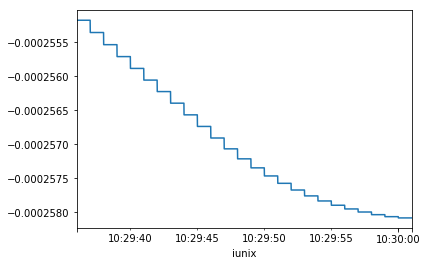

In [5]:
df['AccBiasZ'][10000:15000].plot()

### Filter - butterworth

In [6]:
from scipy import signal

# First, design the Buterworth filter
N  = 4    # Filter order
Wn = .005 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')

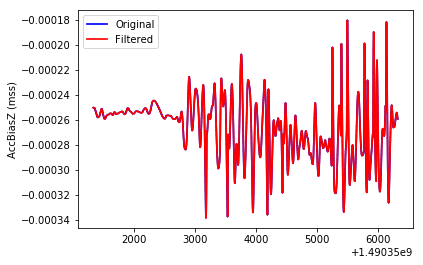

In [7]:
# Second, apply the filter
x = df['UTCTime'][:1000000].values
y = df['AccBiasZ'][:1000000].values
yf = signal.filtfilt(B, A, y)

# Make plots
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(x, y, 'b',linewidth=1.7)
plt.plot(x, yf, 'r',linewidth=1.7)
# plt.xlim([np.nanmin(x)+100, np.nanmin(x)+150])
plt.ylabel("AccBiasZ (mss)")
plt.legend(['Original','Filtered'])
plt.title("")
# ax1.axes.get_xaxis().set_visible(False)

In [8]:
fs = 2 * 10 ** 2

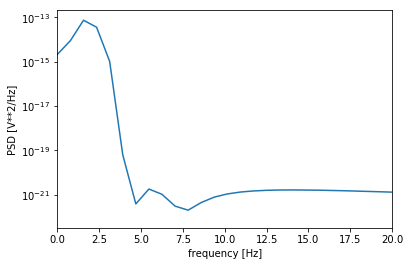

In [9]:
f, Pxx_den = signal.welch(yf[:], fs, 'flattop', 256, scaling='spectrum')
plt.semilogy(f, Pxx_den)
plt.xlim([0, 20])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

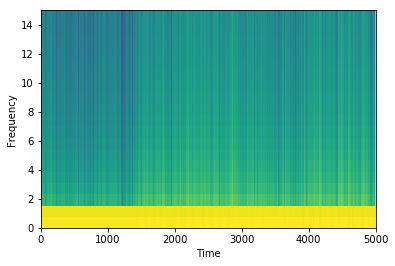

In [15]:
f, t, Zxx = signal.stft(yf, fs, nperseg=256)
plt.pcolormesh(t, f, np.abs(Zxx),norm=matplotlib.colors.LogNorm())
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.ylim([0, 15])
plt.show()


In [ ]:
nout = 1000
# x = df['UTCTime'][:100000].values
# y = df['AccBiasZ'][:100000].values
f = np.linspace(0.01, 10, nout)
pgram = signal.lombscargle(x, yf, f) #, normalize=True
plt.subplot(2, 1, 1)
plt.plot(x, yf, 'b+')
plt.subplot(2, 1, 2)
plt.plot(f, pgram)
plt.xlim([0, 1])
plt.show()

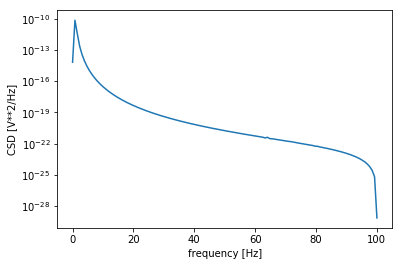

In [12]:
f, Pxy = signal.csd(x, yf, fs, nperseg=256)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

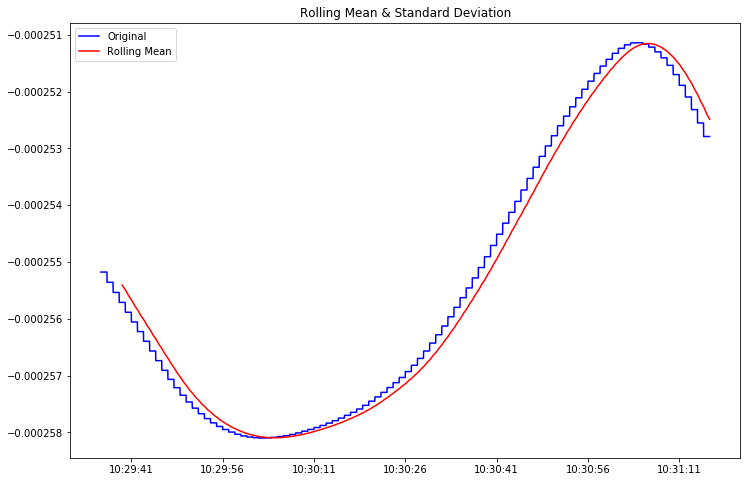

Results of Dickey-Fuller Test:


NameError: global name 'adfuller' is not defined

In [13]:
def test_stationarity(timeseries):
    # Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=7)
    rolmean = timeseries.rolling(window=700).mean()
    rolstd = timeseries.rolling(window=700).std()
    rolres = timeseries - rolmean
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label='Rolling Std')
#     res = plt.plot(rolres, color='green', label='Residual')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print dfoutput
    
test_stationarity(df['AccBiasZ'][10000:30000])

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_pacf(yf.squeeze(), lags=2000, ax=ax1)
# ax2 = fig.add_subplot(212)
# sm.graphics.tsa.plot_acf(df['AccBiasZ'][10000:30000].squeeze(), lags=30, ax=ax2)

/Users/dporter/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
